# Compare Results

Short idea: load metrics from `data/results/` and compare FLAML / TPOT / auto-sklearn with tables and plots.

## AutoML

Plot RMSE vs iteration for the 4 models from an AutoML `state_matrix.json`. The line is highlighted (thicker) while a model is the one being explored (`current_model=True`).

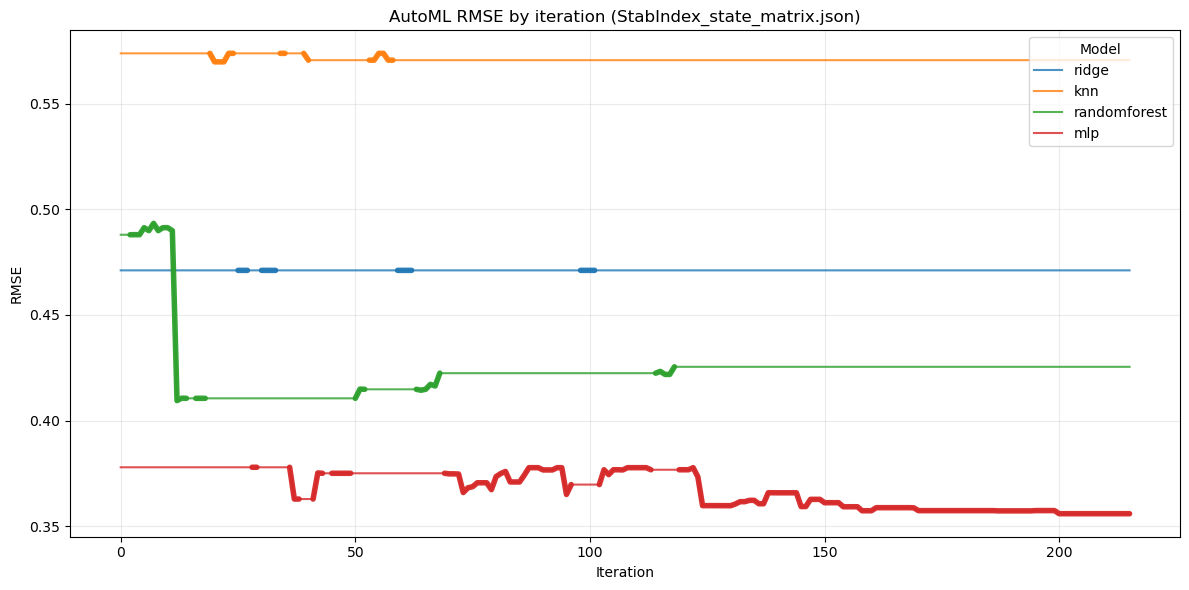

In [10]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Change this file to inspect a different AutoML run
state_matrix_path = Path("../data/results/automl/StabIndex_state_matrix.json")

with state_matrix_path.open("r", encoding="utf-8") as f:
    state_matrix = json.load(f)

rows = []
for iter_key, iter_state in state_matrix.items():
    iter_idx = int(iter_key)
    for model_name, model_state in iter_state.items():
        rows.append({
            "iter": iter_idx,
            "model": model_name,
            "rmse": float(model_state["rmse"]),
            "current_model": bool(model_state.get("current_model", False)),
        })

df = pd.DataFrame(rows).sort_values(["iter", "model"]).reset_index(drop=True)
model_order = [m for m in ["ridge", "knn", "randomforest", "mlp"] if m in df["model"].unique()]
colors = {
    "ridge": "#1f77b4",
    "knn": "#ff7f0e",
    "randomforest": "#2ca02c",
    "mlp": "#d62728",
}

fig, ax = plt.subplots(figsize=(12, 6))

for model_name in model_order:
    d = df[df["model"] == model_name].sort_values("iter").copy()
    c = colors.get(model_name, None)

    # Base trajectory (always visible)
    ax.plot(
        d["iter"],
        d["rmse"],
        label=model_name,
        color=c,
        linewidth=1.5,
        alpha=0.8,
    )

    # Highlight only the iterations where this model is the active/current one
    y_highlight = d["rmse"].where(d["current_model"], np.nan)
    ax.plot(
        d["iter"],
        y_highlight,
        color=c,
        linewidth=4.0,
        alpha=0.95,
        solid_capstyle="round",
    )

ax.set_title(f"AutoML RMSE by iteration ({state_matrix_path.name})")
ax.set_xlabel("Iteration")
ax.set_ylabel("RMSE")
ax.grid(True, alpha=0.25)
ax.legend(title="Model")
plt.tight_layout()
plt.show()

## AutoML vs TPOT

Compare final metrics from `data/results/automl/*_run_summary*.json` and `data/results/tpot/*_run_summary*.json` for the same dataset.

,framework,rmse,r2,mae,mse,elapsed_time_s,model,summary_file
0,automl,0.355948,0.871709,0.271061,0.126733,305.561525,mlp,data\results\automl\StabIndex_run_summary.json
1,tpot,0.351484,0.874531,0.268269,0.123541,327.220783,mlpregressor,data\results\tpot\StabIndex_run_summary.json


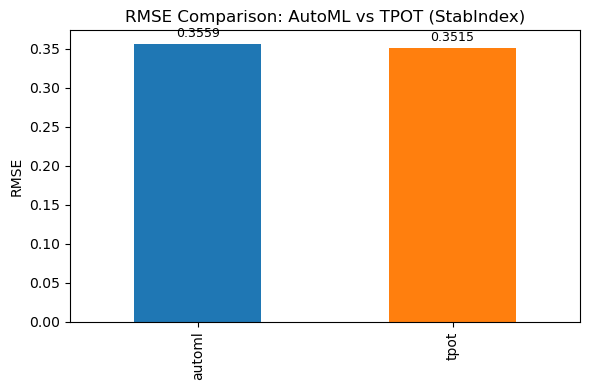

Winner by RMSE: tpot (0.351484 < 0.355948)


In [11]:
from pathlib import Path
import json
import re

import pandas as pd
import matplotlib.pyplot as plt

# Change dataset if needed
dataset_stem = "StabIndex"
cwd = Path.cwd().resolve()
project_root = cwd if (cwd / "data").exists() else cwd.parent

automl_dir = project_root / "data" / "results" / "automl"
tpot_dir = project_root / "data" / "results" / "tpot"

automl_candidates = sorted(
    automl_dir.glob(f"{dataset_stem}_run_summary*.json"),
    key=lambda p: p.stat().st_mtime,
    reverse=True,
)
tpot_candidates = sorted(
    tpot_dir.glob(f"{dataset_stem}_run_summary*.json"),
    key=lambda p: p.stat().st_mtime,
    reverse=True,
)

if not automl_candidates:
    raise FileNotFoundError(f"No AutoML summary found for {dataset_stem} in {automl_dir}")
if not tpot_candidates:
    raise FileNotFoundError(f"No TPOT summary found for {dataset_stem} in {tpot_dir}")

automl_path = automl_candidates[0]
tpot_path = tpot_candidates[0]

with automl_path.open("r", encoding="utf-8") as f:
    automl_summary = json.load(f)
with tpot_path.open("r", encoding="utf-8") as f:
    tpot_summary = json.load(f)

automl_metrics = dict(automl_summary.get("metrics", {}))
if "rmse" not in automl_metrics and "rmse" in automl_summary:
    automl_metrics["rmse"] = float(automl_summary["rmse"])
for key in ["r2", "mae", "mse"]:
    automl_metrics.setdefault(key, None)
automl_rmse = float(automl_metrics["rmse"])

tpot_metrics = tpot_summary.get("metrics", {})
tpot_rmse = float(tpot_metrics["rmse"])

pipeline_hint = str(tpot_summary.get("pipeline_file", ""))
pipeline_path = Path(pipeline_hint) if pipeline_hint else None
if pipeline_path is None or not pipeline_path.exists():
    fallback_candidates = sorted(
        tpot_dir.glob(f"{dataset_stem}_best_pipeline.*"),
        key=lambda p: p.stat().st_mtime,
        reverse=True,
    )
    pipeline_path = fallback_candidates[0] if fallback_candidates else None

best_tpot_model = "unknown"
if pipeline_path is not None and pipeline_path.exists():
    pipeline_text = pipeline_path.read_text(encoding="utf-8", errors="ignore")
    lines = [ln.strip() for ln in pipeline_text.splitlines() if "Regressor(" in ln]
    if lines:
        best_tpot_model = lines[-1].split("(")[0].strip(" ,'\"").lower()
    else:
        class_hits = re.findall(r"([A-Za-z0-9_]+Regressor)\(", pipeline_text)
        if class_hits:
            best_tpot_model = class_hits[-1].lower()

comparison_rows = [
    {
        "framework": "automl",
        "rmse": automl_rmse,
        "r2": automl_metrics.get("r2", None),
        "mae": automl_metrics.get("mae", None),
        "mse": automl_metrics.get("mse", None),
        "elapsed_time_s": float(automl_summary.get("elapsed_time", float("nan"))),
        "model": str(automl_summary.get("best_model", "")),
        "summary_file": str(automl_path.relative_to(project_root)),
    },
    {
        "framework": "tpot",
        "rmse": tpot_rmse,
        "r2": tpot_metrics.get("r2", None),
        "mae": tpot_metrics.get("mae", None),
        "mse": tpot_metrics.get("mse", None),
        "elapsed_time_s": float(tpot_summary.get("elapsed_time", float("nan"))),
        "model": best_tpot_model,
        "summary_file": str(tpot_path.relative_to(project_root)),
    },
]

comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df)

ax = comparison_df.plot(
    x="framework",
    y="rmse",
    kind="bar",
    legend=False,
    figsize=(6, 4),
    color=["#1f77b4", "#ff7f0e"],
)
ax.set_title(f"RMSE Comparison: AutoML vs TPOT ({dataset_stem})")
ax.set_ylabel("RMSE")
ax.set_xlabel("")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=9, xytext=(0, 3), textcoords="offset points")
plt.tight_layout()
plt.show()

if automl_rmse < tpot_rmse:
    print(f"Winner by RMSE: automl ({automl_rmse:.6f} < {tpot_rmse:.6f})")
elif tpot_rmse < automl_rmse:
    print(f"Winner by RMSE: tpot ({tpot_rmse:.6f} < {automl_rmse:.6f})")
else:
    print(f"Tie by RMSE: {automl_rmse:.6f}")
